In [18]:
###Python/3.9.6-GCCcore-11.2.0
##loading packages 
import os
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # default='warn'
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as ticker
import sklearn
from scipy.stats import linregress
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import scipy.stats as st
from sklearn.utils import shuffle
from statannotations.Annotator import Annotator
from scipy.optimize import minimize, rosen, rosen_der
from scipy.stats import norm
from scipy.optimize import minimize_scalar
from scipy.stats import mannwhitneyu, norm
from lifelines import KaplanMeierFitter
from sklearn.metrics import f1_score
import sklearn.metrics
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
import math 
import joblib

In [20]:
##load data
Meta_data = pd.read_excel("Supplementary_Tables_v2.xlsx",sheet_name = 'Supplementary Table 2')
Griffin_scATAC_features = pd.read_excel("Raw_feature_tables.xlsx",sheet_name = 'Raw feature Table 1')
Griffin_DNase_features = pd.read_excel("Raw_feature_tables.xlsx",sheet_name = 'Raw feature Table 2')
Griffin_TFBS_features = pd.read_excel("Raw_feature_tables.xlsx",sheet_name = 'Raw feature Table 3')

#Merge data
feature_matrix_df = pd.merge(Meta_data,Griffin_scATAC_features,on = "sample_ID", how = "inner")
feature_matrix_df = pd.merge(feature_matrix_df,Griffin_DNase_features,on = "sample_ID", how = "inner")
feature_matrix_df = pd.merge(feature_matrix_df,Griffin_TFBS_features,on = "sample_ID", how = "inner")

print("Total samples = ",len(feature_matrix_df))
print("Total sample_ID = ",len(feature_matrix_df['sample_ID'].unique()))

Total samples =  1822
Total sample_ID =  1822


In [3]:
##save trained model
path = './'

In [7]:
## Identify pregnancy specific feats
from scipy.stats import mannwhitneyu
Data_train = feature_matrix_df.copy()
Data_train = Data_train[(Data_train["Cohort"]== "FF-Training Cohort") | (Data_train["Cohort"]=="Non-pregnant-female Cohort")]
print("FF-Training Cohort")
print("num Non_Preg =", len(Data_train[Data_train["Non-Pregnant_Sample"]==1]))
print("num Preg =", len(Data_train[Data_train["Non-Pregnant_Sample"]==0]))
print("")

All_feats = Data_train.columns.to_list()
Selected_feats = [ x for x in All_feats if "120_180_MCV" in x ] + [ x for x in All_feats if "120_180_NDR-30" in x ] +  [ x for x in All_feats if "120_180_NDR-75" in x ] 
Selected_feats = list(set(Selected_feats))

##Select high FF samples
Data_train = Data_train[(Data_train["ChrY_Fetal_Fraction"] > 0.25) | (Data_train["Non-Pregnant_Sample"]==1)]
print("num Non_Preg =", len(Data_train[Data_train["Non-Pregnant_Sample"]==1]))
print("num Preg =", len(Data_train[Data_train["Non-Pregnant_Sample"]==0]))

print("Total num of feats = ",len(Selected_feats))

TF_score = []
from scipy import stats
for each_TF in Selected_feats:
    feature_snip = Data_train[["Non-Pregnant_Sample",each_TF]]
    NOP_vals = feature_snip[feature_snip["Non-Pregnant_Sample"] == 1].values[:,1].astype(np.float64)
    PEP_vals = feature_snip[feature_snip["Non-Pregnant_Sample"] == 0].values[:,1].astype(np.float64)
    NOP_mean = np.median(NOP_vals)
    PEP_mean = np.median(PEP_vals)
    diff = ((np.mean(PEP_vals)/np.mean(NOP_vals)))
    mannU =  mannwhitneyu(NOP_vals, PEP_vals)
    std = np.std(NOP_vals)
    pval = [each_TF,mannU[1],diff,NOP_mean,PEP_mean,std]
    TF_score.append(pval)

TF_col = ["TF","pval","log2_Fold_change","NOP_median","PEP_Median","std"]
TF_pval_df = pd.DataFrame(TF_score, columns = TF_col, index = None)

#Multiple test correction 
from statsmodels.stats.multitest import fdrcorrection
import statsmodels.api as sm
pvals = TF_pval_df['pval'].values
Multitest = sm.stats.multipletests(pvals, alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False)
TF_pval_df['Multitest_bf_Adjusted_pvalue'] = Multitest[1]
TF_pval_df['Multitest_bf_reject'] = Multitest[0]
TF_pval_df = TF_pval_df.sort_values(by ='Multitest_bf_Adjusted_pvalue')

##Select pregnancy specific features
preg_feats = TF_pval_df[TF_pval_df["Multitest_bf_Adjusted_pvalue"]<0.05]["TF"].to_list()
print("num of stat sig =",len(preg_feats))
TF_pval_df.head(10)

FF-Training Cohort
num Non_Preg = 20
num Preg = 380

num Non_Preg = 20
num Preg = 25
Total num of feats =  1239
num of stat sig = 141


,TF,pval,log2_Fold_change,NOP_median,PEP_Median,std,Multitest_bf_Adjusted_pvalue,Multitest_bf_reject
75,Placental_trophoblast_120_180_MCV,1.203926e-08,0.976440,0.998410,0.974800,0.003689,0.000015,True
686,ZSCAN16_120_180_NDR-75,1.205252e-08,0.905893,0.868710,0.790645,0.017905,0.000015,True
589,Placental_120_180_NDR-75,1.205252e-08,0.893413,1.001983,0.897867,0.012453,0.000015,True
973,Placental_120_180_NDR-30,1.205252e-08,0.885588,1.010775,0.895830,0.020987,0.000015,True
503,Placental_trophoblast_120_180_NDR-75,1.205252e-08,0.911134,1.027733,0.933472,0.015126,0.000015,True
95,ZSCAN16_120_180_NDR-30,1.205252e-08,0.900342,0.846315,0.767120,0.027320,0.000015,True
136,Placental_120_180_MCV,1.205252e-08,0.970287,1.003010,0.972160,0.003584,0.000015,True
23,GRHL2_120_180_NDR-75,1.205252e-08,0.927881,0.997440,0.924863,0.014924,0.000015,True
1028,GRHL2_120_180_MCV,1.377680e-08,0.984427,0.990460,0.973900,0.003842,0.000017,True
533,ZSCAN4_120_180_NDR-75,1.377680e-08,0.797347,0.514501,0.411969,0.024367,0.000017,True


In [8]:
Meta_data.head()

,sample_ID,Cohort,Outcome,Subtype,NIPS_gestational_age,Year,mean_sequencing_coverage,ChrY_Fetal_Fraction,Griffin_Fetal_Fraction,Neonatal_Sex,Non-Pregnant_Sample,Maternal_age,NIPS_Maternal_bmi,NIPS_sbp,NIPS_dbp,Onset_of_hypertension_Gestational_age,Delivery_Gestational_age,Birthweight,Chronic_hypertension,Pre_gestational_diabetes,race,ethnicity
0,P4,Screening Cohort,NP,NP,11.428571,2017,0.753189,-0.008733,0.145604,2,0,39,21.963505,116,79,NaN,39.714286,3258,0,0,5,1
1,P1,Screening Cohort,PE,LOPE-TB,12.142857,2017,0.542231,0.098206,0.156523,1,0,39,35.338593,112,64,37.428571,37.428571,3019,0,1,5,2
2,P3,Screening Cohort,NP,NP,12.000000,2017,0.717252,0.154607,0.185625,1,0,31,22.075479,108,69,NaN,39.571429,NaN,0,0,5,2
3,P2,Screening Cohort,NP,NP,10.285714,2017,0.571194,0.060744,0.075060,1,0,37,24.0625,96,64,NaN,39.714286,3064,0,0,2,2
4,P6,Screening Cohort,NP,NP,13.000000,2017,0.454194,-0.006927,0.115324,2,0,40,23.1012,110,60,NaN,41.857143,4020,0,0,5,2


In [9]:
##Train Griffin FF model on blinded samples
Data_train = feature_matrix_df.copy()
Data_train = Data_train[(Data_train["Cohort"]== "FF-Training Cohort") | (Data_train["Cohort"]=="Non-pregnant-female Cohort")]
print("Total blinded training samples for Griffin FF = ",len(Data_train))

##Select pregnancy specific features
Selected_feats = preg_feats
X = Data_train[Selected_feats]
y = Data_train["ChrY_Fetal_Fraction"]
clf = linear_model.BayesianRidge(n_iter=1000) ##works great!
clf.fit(X,y)
print("Total features",len(Selected_feats))

##save model
joblib.dump(clf, path + 'Griffin_FF.joblib')
Selected_feats_DF = pd.DataFrame(Selected_feats)
Selected_feats_DF.to_csv(path + 'Griffin_FF_feats.csv',index=False)

##Estimate Griffin FF for all samples
Datatest = feature_matrix_df.copy()
X =  Datatest[Selected_feats]

Griffin_FF = clf.predict(X)
feature_matrix_df["Griffin_FF"] = Griffin_FF
print("Griffin-FF Fetal Fraction Estimated")

Total blinded training samples for Griffin FF =  400
Total features 141
Griffin-FF Fetal Fraction Estimated


In [10]:
##PE prediction for PE training cohort
data = feature_matrix_df.copy()

current_DF = data[data["Cohort"]== "PE-Training Cohort"]
PE_Training_samples = list(current_DF['sample_ID'].unique())
print("Total samples in PE-Training cohort =",len(current_DF))
for each_sub in current_DF["Subtype"].unique():
    current = current_DF[current_DF["Subtype"]==each_sub]
    print(each_sub,"=",len(current))

print("")

current_DF = data[data["Cohort"]== "Screening Cohort"]
PE_Training_samples = list(current_DF['sample_ID'].unique())
print("Total samples in PE Screening cohort =",len(current_DF))
for each_sub in current_DF["Subtype"].unique():
    current = current_DF[current_DF["Subtype"]==each_sub]
    print(each_sub,"=",len(current))


Total samples in PE-Training cohort = 454
NP = 316
LOPE-TB = 58
EOPE = 38
LOPE-PB = 42

Total samples in PE Screening cohort = 789
NP = 690
LOPE-TB = 77
LOPE-PB = 11
EOPE = 11


In [11]:
##Feats for PE risk prediction

Normalize_feats =  ['Griffin_FF',
 'NIPS_sbp',
 'NIPS_dbp',
 'NIPS_Maternal_bmi',
 'Placental_120_180_MCV',
 'Placental_trophoblast_120_180_MCV',
 'Placental_120_180_NDR-30',
 'Placental_120_180_NDR-75',
 'Placental_trophoblast_120_180_NDR-30',
 'Placental_trophoblast_120_180_NDR-75',
 'Placental_35_80_NDR-30',
 'Placental_trophoblast_35_80_NDR-30',
 'Endothelial_120_180_MCV',
 'Vascular_endothelial_120_180_MCV',
 'Endothelial_120_180_NDR-30',
 'Endothelial_120_180_NDR-75',
 'Vascular_endothelial_120_180_NDR-30',
 'Vascular_endothelial_120_180_NDR-75',
 'Endothelial_35_80_NDR-30',
 'Vascular_endothelial_35_80_NDR-30']

feat_sets = [['Griffin_FF',
  'Placental_120_180_MCV',
  'Placental_trophoblast_120_180_MCV',
  'Placental_120_180_NDR-30',
  'Placental_120_180_NDR-75',
  'Placental_trophoblast_120_180_NDR-30',
  'Placental_trophoblast_120_180_NDR-75',
  'Placental_35_80_NDR-30',
  'Placental_trophoblast_35_80_NDR-30',
  'Endothelial_120_180_MCV',
  'Vascular_endothelial_120_180_MCV',
  'Endothelial_120_180_NDR-30',
  'Endothelial_120_180_NDR-75',
  'Vascular_endothelial_120_180_NDR-30',
  'Vascular_endothelial_120_180_NDR-75',
  'Endothelial_35_80_NDR-30',
  'Vascular_endothelial_35_80_NDR-30'],
 ['NIPS_sbp', 'NIPS_dbp', 'NIPS_Maternal_bmi'],
 ['Griffin_FF',
  'NIPS_sbp',
  'NIPS_dbp',
  'NIPS_Maternal_bmi',
  'Placental_120_180_MCV',
  'Placental_trophoblast_120_180_MCV',
  'Placental_120_180_NDR-30',
  'Placental_120_180_NDR-75',
  'Placental_trophoblast_120_180_NDR-30',
  'Placental_trophoblast_120_180_NDR-75',
  'Placental_35_80_NDR-30',
  'Placental_trophoblast_35_80_NDR-30',
  'Endothelial_120_180_MCV',
  'Vascular_endothelial_120_180_MCV',
  'Endothelial_120_180_NDR-30',
  'Endothelial_120_180_NDR-75',
  'Vascular_endothelial_120_180_NDR-30',
  'Vascular_endothelial_120_180_NDR-75',
  'Endothelial_35_80_NDR-30',
  'Vascular_endothelial_35_80_NDR-30']]

Total samples in PE-Training cohort = 454
NP = 316
LOPE-TB = 58
EOPE = 38
LOPE-PB = 42
Num of bootstrap = 20
Num of feats = 17 ['Griffin_FF', 'Placental_120_180_MCV', 'Placental_trophoblast_120_180_MCV', 'Placental_120_180_NDR-30', 'Placental_120_180_NDR-75', 'Placental_trophoblast_120_180_NDR-30', 'Placental_trophoblast_120_180_NDR-75', 'Placental_35_80_NDR-30', 'Placental_trophoblast_35_80_NDR-30', 'Endothelial_120_180_MCV', 'Vascular_endothelial_120_180_MCV', 'Endothelial_120_180_NDR-30', 'Endothelial_120_180_NDR-75', 'Vascular_endothelial_120_180_NDR-30', 'Vascular_endothelial_120_180_NDR-75', 'Endothelial_35_80_NDR-30', 'Vascular_endothelial_35_80_NDR-30']
NP    316
PE    138
Name: Outcome, dtype: int64
#Performance metrics

specificity 0.7
AUC 0.76 CI95 (0.7, 0.82)
Specificity 0.7 Sensitivity 0.71 CI95 (0.59, 0.84)
AUC 0.67 CI95 (0.61, 0.73)
Specificity 0.7 Sensitivity 0.53 CI95 (0.45, 0.64)
AUC 0.56 CI95 (0.5, 0.63)
Specificity 0.7 Sensitivity 0.32 CI95 (0.23, 0.5)

specificity 

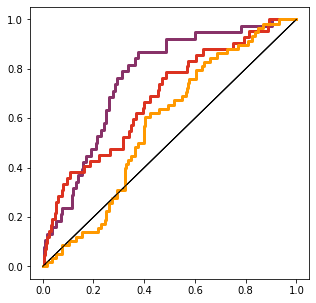

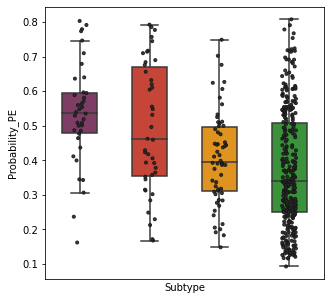

Num of feats = 3 ['NIPS_sbp', 'NIPS_dbp', 'NIPS_Maternal_bmi']
NP    316
PE    138
Name: Outcome, dtype: int64
#Performance metrics

specificity 0.7
AUC 0.77 CI95 (0.71, 0.87)
Specificity 0.7 Sensitivity 0.73 CI95 (0.61, 0.89)
AUC 0.65 CI95 (0.57, 0.72)
Specificity 0.7 Sensitivity 0.48 CI95 (0.35, 0.63)
AUC 0.62 CI95 (0.57, 0.69)
Specificity 0.7 Sensitivity 0.39 CI95 (0.29, 0.48)

specificity 0.8
AUC 0.77 CI95 (0.71, 0.87)
Specificity 0.8 Sensitivity 0.68 CI95 (0.48, 0.67)
AUC 0.65 CI95 (0.57, 0.72)
Specificity 0.8 Sensitivity 0.42 CI95 (0.27, 0.42)
AUC 0.62 CI95 (0.57, 0.69)
Specificity 0.8 Sensitivity 0.32 CI95 (0.16, 0.32)

specificity 0.9
AUC 0.77 CI95 (0.71, 0.87)
Specificity 0.9 Sensitivity 0.6 CI95 (0.29, 0.54)
AUC 0.65 CI95 (0.57, 0.72)
Specificity 0.9 Sensitivity 0.36 CI95 (0.12, 0.29)
AUC 0.62 CI95 (0.57, 0.69)
Specificity 0.9 Sensitivity 0.26 CI95 (0.05, 0.17)


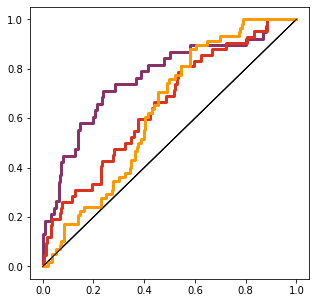

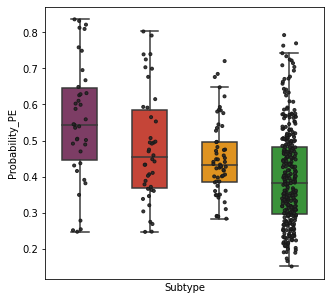

Num of feats = 20 ['Griffin_FF', 'NIPS_sbp', 'NIPS_dbp', 'NIPS_Maternal_bmi', 'Placental_120_180_MCV', 'Placental_trophoblast_120_180_MCV', 'Placental_120_180_NDR-30', 'Placental_120_180_NDR-75', 'Placental_trophoblast_120_180_NDR-30', 'Placental_trophoblast_120_180_NDR-75', 'Placental_35_80_NDR-30', 'Placental_trophoblast_35_80_NDR-30', 'Endothelial_120_180_MCV', 'Vascular_endothelial_120_180_MCV', 'Endothelial_120_180_NDR-30', 'Endothelial_120_180_NDR-75', 'Vascular_endothelial_120_180_NDR-30', 'Vascular_endothelial_120_180_NDR-75', 'Endothelial_35_80_NDR-30', 'Vascular_endothelial_35_80_NDR-30']
NP    316
PE    138
Name: Outcome, dtype: int64
#Performance metrics

specificity 0.7
AUC 0.81 CI95 (0.76, 0.87)
Specificity 0.7 Sensitivity 0.78 CI95 (0.68, 0.91)
AUC 0.72 CI95 (0.68, 0.78)
Specificity 0.7 Sensitivity 0.6 CI95 (0.46, 0.72)
AUC 0.6 CI95 (0.55, 0.66)
Specificity 0.7 Sensitivity 0.4 CI95 (0.31, 0.52)

specificity 0.8
AUC 0.81 CI95 (0.76, 0.87)
Specificity 0.8 Sensitivity 0.73 

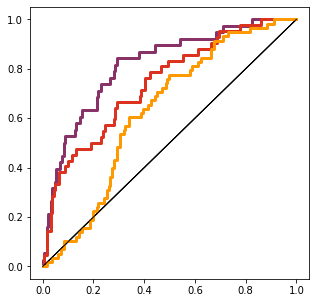

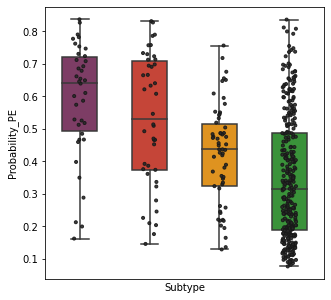

In [12]:
##PE prediction for PE training cohort
data = feature_matrix_df.copy()
data = data[data["Cohort"]== "PE-Training Cohort"]

#Create scalar
scaler = StandardScaler()
scaler.fit(data[Normalize_feats])

print("Total samples in PE-Training cohort =",len(data))
for each_sub in data["Subtype"].unique():
    current = data[data["Subtype"]==each_sub]
    print(each_sub,"=",len(current))

##Define parameters
bootstrap_n = 1000
specificity_list = [0.70,0.80,0.90]
print("Num of bootstrap =",bootstrap_n)

Samples = data[["sample_ID"]]
set_n = -1
All_Model_output = data[["sample_ID"]]
for each_featset in feat_sets:
    set_n = set_n  + 1
    Final_ML_feats = each_featset
    print("Num of feats =",len(Final_ML_feats),Final_ML_feats)
    data_Transformed = data.copy()
    #print('Feature names',scaler.get_feature_names_out())
    data_Transformed[Normalize_feats] = scaler.transform(data_Transformed[Normalize_feats])

    subs = ["NP",'PE']
    #print(data_Transformed["Status"].unique())
    print(data_Transformed["Outcome"].value_counts())

    data_Transformed = data_Transformed[data_Transformed["Outcome"].isin(subs)]
    from sklearn import preprocessing    
    le = preprocessing.LabelEncoder()
    le.fit(data_Transformed["Outcome"].values)
    data_Transformed["Outcome"] = le.transform(data_Transformed["Outcome"].values)

    confidence_array = []
    plt.figure(figsize=(5, 5))
    for i in range(1,bootstrap_n+1):       
        ##sample from NP and Severe PE
        NP_samples = data_Transformed[(data_Transformed["Subtype"]=="NP")][["sample_ID"]] 
        NP_samples = NP_samples.sample(len(NP_samples), replace = True, random_state = i)

        subs = ['EOPE','LOPE-PB','LOPE-TB']
        PE_samples = []
        for each_sub in subs:
            current_Samples = data_Transformed[(data_Transformed["Subtype"]==each_sub)][["sample_ID"]]
            current_Samples = current_Samples.sample(len(current_Samples), replace = True, random_state = i).drop_duplicates()
            current_Samples = current_Samples["sample_ID"].to_list()
            PE_samples = PE_samples + current_Samples
        PE_samples = pd.DataFrame(PE_samples,columns = ["sample_ID"])
        
        #PE_samples = data_Transformed[(data_Transformed["Subtype"].isin(subs))][["sample_ID"]]
        PE_samples = PE_samples.sample(len(PE_samples), replace = True, random_state = i)

        
        Train_samples = pd.concat([NP_samples,PE_samples],axis =0)
        
        Test_samples = Samples[~Samples["sample_ID"].isin(Train_samples["sample_ID"])]
        
        #Train classifiers 
        Train_data = pd.merge(Train_samples,data_Transformed,on = "sample_ID",how = "inner")
        Test_data = pd.merge(Test_samples,data_Transformed,on = "sample_ID",how = "inner")

        X_train = Train_data.set_index('sample_ID')[Final_ML_feats]
        y_train = Train_data.set_index('sample_ID')["Outcome"]

        clf_1 = LogisticRegression(penalty= 'l1', solver='liblinear', C =1 ,max_iter=1000,class_weight = 'balanced')
        clf_1.fit(X_train, y_train)
        
        clf_2 = LogisticRegression(penalty= 'l2', solver='liblinear', C =1 ,max_iter=1000,class_weight = 'balanced')
        clf_2.fit(X_train, y_train)

        clf_3 = xgb.XGBClassifier(n_estimators=10,max_depth=5,eta=0.1,subsample=0.8,colsample_bytree=1)
        clf_3.fit(X_train, y_train)

        #Test classifiers
        X_test = Test_data.set_index('sample_ID')[Final_ML_feats]
        y_test = Test_data.set_index('sample_ID')[["Outcome"]]
        
        predict_proba_clf = pd.DataFrame()
        predict_proba_clf["clf_1"] = clf_1.predict_proba(X_test)[:,1].tolist()
        predict_proba_clf["clf_2"] = clf_2.predict_proba(X_test)[:,1].tolist()
        predict_proba_clf["clf_3"] = clf_3.predict_proba(X_test)[:,1].tolist()        
        classifiers = ['clf_1','clf_2','clf_3']#'clf_1','clf_2','clf_3'
        predict_proba_clf_merged = predict_proba_clf[classifiers].mean(axis=1).to_list() 

        weights_cv = list(zip(y_test.index.to_list(),predict_proba_clf["clf_1"],predict_proba_clf["clf_2"],predict_proba_clf["clf_3"],predict_proba_clf_merged,y_test["Outcome"].to_list(),[i]*len(X_test)))    
        confidence_array += weights_cv

    Model_output = pd.DataFrame(confidence_array)
    Model_output.columns = ["sample_ID","Prob_1" ,"Prob_2" ,"Prob_3","Prob","Actual","iter"]
    
    #Plot ROC
    print("#Performance metrics")
    Sensitivity_range_DF = []
    subs = ['EOPE','LOPE-PB','LOPE-TB']
    color = ["#883268","#DC3220","#FF9900","#2ca02c"] 
    for each_specificity in specificity_list:
        print("")
        print("specificity",each_specificity)
        AUC_range = []
        for i in range(1,bootstrap_n+1):    
            AUC_sub = []
            Sensitivity_sub_DF = []
            n = -1
            for sub in subs:
                n +=1
                current_DF = pd.merge(Model_output,data_Transformed[["sample_ID","Subtype","Outcome"]])      
                current_DF = current_DF[current_DF["iter"]==i]
                if len(current_DF[current_DF["Subtype"]==sub]) > 0:
                    current_DF = current_DF[(current_DF["Subtype"] == "NP")|(current_DF["Subtype"]==sub) ]
                    AUC = roc_auc_score(current_DF["Actual"],current_DF["Prob"].values)
                    AUC_sub.append(AUC)
                    fpr, tpr, thresholds = roc_curve(current_DF["Actual"], current_DF["Prob"].values)        
                    Sensitivity = round(tpr[sum(fpr <= 1 - each_specificity)],2)
                    Sensitivity_sub_DF.append(Sensitivity)
            AUC_range.append(AUC_sub)
            Sensitivity_range_DF.append(Sensitivity_sub_DF)
        AUC_DF = pd.DataFrame(AUC_range,columns =subs)
        AUC_DF = AUC_DF.dropna()
        Sensitivity_DF = pd.DataFrame(Sensitivity_range_DF,columns =subs)
        Sensitivity_DF = Sensitivity_DF.dropna()

        for sub in subs:
            CI95 = round(list(AUC_DF[sub].sort_values())[int(bootstrap_n*0.05)],2),round(list(AUC_DF[sub].sort_values())[int(bootstrap_n*0.95)],2)
            print("AUC",round(AUC_DF[sub].mean(),2),"CI95",CI95)
            CI95 = round(list(Sensitivity_DF[sub].sort_values())[int(bootstrap_n*0.05)],2),round(list(Sensitivity_DF[sub].sort_values())[int(bootstrap_n*0.95)],2)
            print("Specificity",each_specificity,"Sensitivity",round(Sensitivity_DF[sub].mean(),2),"CI95",CI95)

    median_prob_list = []
    for each_sample in  data_Transformed["sample_ID"].unique():
        current = Model_output[Model_output["sample_ID"]==each_sample]
        current = current[['Prob_1', 'Prob_2', 'Prob_3',"Prob"]].median()
        current_vals =  [each_sample] + current.to_list()
        median_prob_list.append(current_vals)
    median_DF = pd.DataFrame(median_prob_list)
    median_DF.columns = ["sample_ID","Prob_1","Prob_2","Prob_3","Prob_median"]
    All_Model_output = pd.merge(All_Model_output,median_DF.rename(columns={'Prob_1': "Prob_1_" + str(set_n),'Prob_2': "Prob_2_" + str(set_n),'Prob_3': 'Prob_3_' + str(set_n),'Prob_median': "Prob_median_" + str(set_n) }),on = "sample_ID",how = "inner")    

    median_DF = pd.merge(median_DF,data_Transformed[["sample_ID","Outcome","Subtype"]],on = "sample_ID",how = "inner")
    median_DF = median_DF.dropna()
    
    n = -1
    for sub in subs:
        n+=1
        current_DF = median_DF.copy()      
        current_DF = current_DF[(current_DF["Subtype"] == "NP")|(current_DF["Subtype"]==sub) ]
        AUC = roc_auc_score(current_DF["Outcome"],current_DF["Prob_median"].values)
        fpr, tpr, thresholds = roc_curve(current_DF["Outcome"], current_DF["Prob_median"].values)
        plt.plot(fpr,tpr, alpha = 1,lw =3,label = sub,color = color[n])
        plt.plot([0, 1], [0, 1], color='black',lw = 1);
    plt.savefig(path + '/Training_Prob_ROC_set'+ str(set_n) +'.pdf', bbox_inches='tight');     
    plt.show()

    #plt.figure(figsize=(10, 2))
    plt.figure(figsize=(5, 5))
    subs_with_NP = subs + ["NP"]
    ax = sns.boxplot(x="Subtype", y="Prob_median", data=median_DF,order =subs_with_NP ,width = 0.5,fliersize=0,palette=color)
    ax = sns.stripplot(x="Subtype", y="Prob_median", data=median_DF,order =subs_with_NP,color=".16",linewidth=1,alpha = 0.9,size=3,jitter=True)
    plt.xticks(rotation='vertical')
    plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off;
    plt.ylabel("Probability_PE");
    plt.show();

In [13]:
##Save PE risk probabilities 
All_Model_output = All_Model_output[['sample_ID','Prob_median_0','Prob_median_1','Prob_median_2']]
All_Model_output.columns = ['sample_ID','Tissue_prob', 'Clinical_prob', 'Combined_prob']
All_Model_output.to_csv(path + "/Training_model_output.csv",index = False)
All_Model_output

,sample_ID,Tissue_prob,Clinical_prob,Combined_prob
0,P1054,0.505216,0.417601,0.517795
1,P1055,0.248588,0.315882,0.176874
2,P1060,0.548864,0.533159,0.526660
3,P1056,0.676439,0.463744,0.650713
4,P1062,0.416496,0.574767,0.466852
...,...,...,...,...
449,P1816,0.535242,0.539264,0.600961
450,P1817,0.563178,0.648725,0.678830
451,P1818,0.378351,0.303107,0.203791
452,P1820,0.519443,0.631529,0.685827


In [14]:
##Train on all samples from PE-Training cohort and apply to all Screening Cohort samples 
Data_train = feature_matrix_df.copy()
Data_train = Data_train[Data_train["Cohort"]== "PE-Training Cohort"]

scaler = StandardScaler()
scaler.fit(Data_train[Normalize_feats])
joblib.dump(scaler, path + 'scaler.joblib')
Data_train[Normalize_feats] = scaler.transform(Data_train[Normalize_feats])

print("Total samples in PE training cohort =",len(Data_train))

for each_sub in Data_train["Subtype"].unique():
    current = Data_train[Data_train["Subtype"]==each_sub]
    print(each_sub,"=",len(current))

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y = Data_train.set_index('sample_ID')["Outcome"].values 
le.fit(y)
y = le.transform(y)
Data_train["Outcome"] = y
clf_1_1 = LogisticRegression(penalty= 'l1', solver='liblinear', C =1 ,max_iter=1000,class_weight = 'balanced')
X = Data_train.set_index('sample_ID')[feat_sets[0]]
y = Data_train.set_index('sample_ID')["Outcome"]
clf_1_1.fit(X, y)
joblib.dump(clf_1_1, path + 'clf_1_1.joblib')

clf_1_2 = LogisticRegression(penalty= 'l2', solver='liblinear', C =1 ,max_iter=1000,class_weight = 'balanced')
X = Data_train.set_index('sample_ID')[feat_sets[0]]
y = Data_train.set_index('sample_ID')["Outcome"]
clf_1_2.fit(X, y)
joblib.dump(clf_1_2, path + 'clf_1_2.joblib')

clf_1_3 = xgb.XGBClassifier(n_estimators=10,max_depth=5,eta=0.1,subsample=0.8,colsample_bytree=1)
X = Data_train.set_index('sample_ID')[feat_sets[0]]
y = Data_train.set_index('sample_ID')["Outcome"]
clf_1_3.fit(X, y)
joblib.dump(clf_1_3, path + 'clf_1_3.joblib')

clf_2_1 = LogisticRegression(penalty= 'l1', solver='liblinear', C =1 ,max_iter=1000,class_weight = 'balanced')
X = Data_train.set_index('sample_ID')[feat_sets[1]]
y = Data_train.set_index('sample_ID')["Outcome"]
clf_2_1.fit(X, y)
joblib.dump(clf_2_1, path + 'clf_2_1.joblib')

clf_2_2 = LogisticRegression(penalty= 'l2', solver='liblinear', C =1 ,max_iter=1000,class_weight = 'balanced')
X = Data_train.set_index('sample_ID')[feat_sets[1]]
y = Data_train.set_index('sample_ID')["Outcome"]
clf_2_2.fit(X, y)
joblib.dump(clf_2_2, path + 'clf_2_2.joblib')

clf_2_3 = xgb.XGBClassifier(n_estimators=10,max_depth=5,eta=0.1,subsample=0.8,colsample_bytree=1)
X = Data_train.set_index('sample_ID')[feat_sets[1]]
y = Data_train.set_index('sample_ID')["Outcome"]
clf_2_3.fit(X, y)
joblib.dump(clf_2_3, path + 'clf_2_3.joblib')

clf_3_1 = LogisticRegression(penalty= 'l1', solver='liblinear', C =1 ,max_iter=1000,class_weight = 'balanced')
X = Data_train.set_index('sample_ID')[feat_sets[2]]
y = Data_train.set_index('sample_ID')["Outcome"]
clf_3_1.fit(X, y)
joblib.dump(clf_3_1, path + 'clf_3_1.joblib')

clf_3_2 = LogisticRegression(penalty= 'l2', solver='liblinear', C =1 ,max_iter=1000,class_weight = 'balanced')
X = Data_train.set_index('sample_ID')[feat_sets[2]]
y = Data_train.set_index('sample_ID')["Outcome"]
clf_3_2.fit(X, y)
joblib.dump(clf_3_2, path + 'clf_3_2.joblib')

clf_3_3 = xgb.XGBClassifier(n_estimators=10,max_depth=5,eta=0.1,subsample=0.8,colsample_bytree=1)
X = Data_train.set_index('sample_ID')[feat_sets[2]]
y = Data_train.set_index('sample_ID')["Outcome"]
clf_3_3.fit(X, y)
joblib.dump(clf_3_3, path + 'clf_3_3.joblib')

print("Trained models saved")

Total samples in PE training cohort = 454
NP = 316
LOPE-TB = 58
EOPE = 38
LOPE-PB = 42
Trained models saved


In [15]:
##Apply model to all samples
#Data_test = Transformed_data.copy()
data = feature_matrix_df.copy()
data = data[data["Cohort"]== "Screening Cohort"]
print("Test data",len(data))

Data_test = data.copy()
Data_test[Normalize_feats] = scaler.transform(Data_test[Normalize_feats])

X = Data_test.set_index('sample_ID')[feat_sets[0]]
confidence_1_1 = clf_1_1.predict_proba(X)[:,1].tolist()
confidence_1_2 = clf_1_2.predict_proba(X)[:,1].tolist()
confidence_1_3 = clf_1_3.predict_proba(X)[:,1].tolist()

Data_test = data.copy()
Data_test[Normalize_feats] = scaler.transform(Data_test[Normalize_feats])

X = Data_test.set_index('sample_ID')[feat_sets[1]]
confidence_2_1 = clf_2_1.predict_proba(X)[:,1].tolist()
confidence_2_2 = clf_2_2.predict_proba(X)[:,1].tolist()
confidence_2_3 = clf_2_3.predict_proba(X)[:,1].tolist()

Data_test = data.copy()
Data_test[Normalize_feats] = scaler.transform(Data_test[Normalize_feats])

X = Data_test.set_index('sample_ID')[feat_sets[2]]
confidence_3_1 = clf_3_1.predict_proba(X)[:,1].tolist()
confidence_3_2 = clf_3_2.predict_proba(X)[:,1].tolist()
confidence_3_3 = clf_3_3.predict_proba(X)[:,1].tolist()

current_output = pd.DataFrame(index = X.index)
current_output["Tissue_prob_1_1"] = confidence_1_1
current_output["Tissue_prob_1_2"] = confidence_1_2
current_output["Tissue_prob_1_3"] = confidence_1_3

current_output["Clinical_prob_2_1"] = confidence_2_1
current_output["Clinical_prob_2_2"] = confidence_2_2
current_output["Clinical_prob_2_3"] = confidence_2_3

current_output["Prob_Combined_3_1"] = confidence_3_1
current_output["Prob_Combined_3_2"] = confidence_3_2
current_output["Prob_Combined_3_3"] = confidence_3_3

#Soft average of three classifiers 
current_output["Tissue_prob"] = current_output[["Tissue_prob_1_1","Tissue_prob_1_2","Tissue_prob_1_3"]].mean(axis =1)
current_output["Clinical_prob"] = current_output[["Clinical_prob_2_1","Clinical_prob_2_2","Clinical_prob_2_3"]].mean(axis =1)
current_output["Combined_prob"] = current_output[["Prob_Combined_3_1","Prob_Combined_3_2","Prob_Combined_3_3"]].mean(axis =1)

Model_output = pd.DataFrame(index = data["sample_ID"])
Model_output = pd.merge(Model_output, current_output, left_index=True, right_index=True)
Model_output = pd.merge(Model_output,Meta_data, on = 'sample_ID', how = 'inner')
Model_output = pd.merge(Model_output,data[["sample_ID","Griffin_FF"]], on = 'sample_ID', how = 'inner')
Model_output.head()

Test data 789


,sample_ID,Tissue_prob_1_1,Tissue_prob_1_2,Tissue_prob_1_3,Clinical_prob_2_1,Clinical_prob_2_2,Clinical_prob_2_3,Prob_Combined_3_1,Prob_Combined_3_2,Prob_Combined_3_3,Tissue_prob,Clinical_prob,Combined_prob,Cohort,Outcome,Subtype,NIPS_gestational_age,Year,mean_sequencing_coverage,ChrY_Fetal_Fraction,Griffin_Fetal_Fraction,Neonatal_Sex,Non-Pregnant_Sample,Maternal_age,NIPS_Maternal_bmi,NIPS_sbp,NIPS_dbp,Onset_of_hypertension_Gestational_age,Delivery_Gestational_age,Birthweight,Chronic_hypertension,Pre_gestational_diabetes,race,ethnicity,Griffin_FF
0,P4,0.792582,0.808320,0.589568,0.477428,0.475574,0.350738,0.791405,0.810865,0.554064,0.730157,0.434580,0.718778,Screening Cohort,NP,NP,11.428571,2017,0.753189,-0.008733,0.145604,2,0,39,21.963505,116,79,NaN,39.714286,3258,0,0,5,1,0.145604
1,P1,0.349699,0.339600,0.369541,0.481340,0.478554,0.420624,0.353238,0.335850,0.330056,0.352946,0.460173,0.339715,Screening Cohort,PE,LOPE-TB,12.142857,2017,0.542231,0.098206,0.156523,1,0,39,35.338593,112,64,37.428571,37.428571,3019,0,1,5,2,0.156523
2,P3,0.417260,0.420013,0.389232,0.353594,0.349403,0.305004,0.328785,0.326687,0.310380,0.408835,0.336000,0.321951,Screening Cohort,NP,NP,12.000000,2017,0.717252,0.154607,0.185625,1,0,31,22.075479,108,69,NaN,39.571429,NaN,0,0,5,2,0.185625
3,P2,0.619409,0.627307,0.465771,0.248807,0.245196,0.227551,0.354790,0.373934,0.314464,0.570829,0.240518,0.347729,Screening Cohort,NP,NP,10.285714,2017,0.571194,0.060744,0.075060,1,0,37,24.0625,96,64,NaN,39.714286,3064,0,0,2,2,0.075060
4,P6,0.416039,0.407594,0.378906,0.338337,0.331699,0.279654,0.288748,0.280129,0.346873,0.400846,0.316563,0.305250,Screening Cohort,NP,NP,13.000000,2017,0.454194,-0.006927,0.115324,2,0,40,23.1012,110,60,NaN,41.857143,4020,0,0,5,2,0.115324


In [16]:
##Save PE risk probabilities 
All_Model_output = Model_output[['sample_ID','Tissue_prob', 'Clinical_prob', 'Combined_prob']]
All_Model_output.to_csv(path + "/Screening_model_output.csv",index = False)
All_Model_output

,sample_ID,Tissue_prob,Clinical_prob,Combined_prob
0,P4,0.730157,0.434580,0.718778
1,P1,0.352946,0.460173,0.339715
2,P3,0.408835,0.336000,0.321951
3,P2,0.570829,0.240518,0.347729
4,P6,0.400846,0.316563,0.305250
...,...,...,...,...
784,P1044,0.694055,0.556804,0.693297
785,P1046,0.413332,0.625167,0.626349
786,P1045,0.269670,0.268278,0.222408
787,P1048,0.538690,0.337788,0.403719


Total samples in PE validation cohort = 789
Total 0    690
1     99
Name: Actual, dtype: int64
NP = 690
LOPE-TB = 77
LOPE-PB = 11
EOPE = 11
#Performance metrics
bootstrap_n 20
## Tissue_prob

specificity 0.7
AUC 0.76 CI95 (0.7, 0.82)
Specificity 0.7 Sensitivity 0.7 CI95 (0.57, 0.88)
AUC 0.73 CI95 (0.68, 0.82)
Specificity 0.7 Sensitivity 0.56 CI95 (0.43, 0.86)
AUC 0.53 CI95 (0.48, 0.6)
Specificity 0.7 Sensitivity 0.29 CI95 (0.2, 0.4)

specificity 0.8
AUC 0.76 CI95 (0.7, 0.82)
Specificity 0.8 Sensitivity 0.39 CI95 (0.2, 0.67)
AUC 0.73 CI95 (0.68, 0.82)
Specificity 0.8 Sensitivity 0.45 CI95 (0.25, 0.67)
AUC 0.53 CI95 (0.48, 0.6)
Specificity 0.8 Sensitivity 0.21 CI95 (0.14, 0.3)

specificity 0.9
AUC 0.76 CI95 (0.7, 0.82)
Specificity 0.9 Sensitivity 0.14 CI95 (0.0, 0.5)
AUC 0.73 CI95 (0.68, 0.82)
Specificity 0.9 Sensitivity 0.22 CI95 (0.0, 0.57)
AUC 0.53 CI95 (0.48, 0.6)
Specificity 0.9 Sensitivity 0.12 CI95 (0.07, 0.22)

EOPE Sensitivity at specificity 70 =  0.73
EOPE Sensitivity at specif

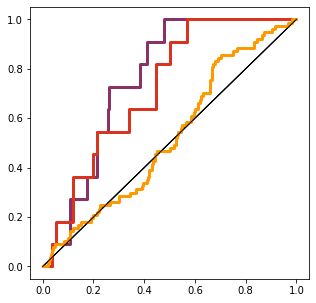

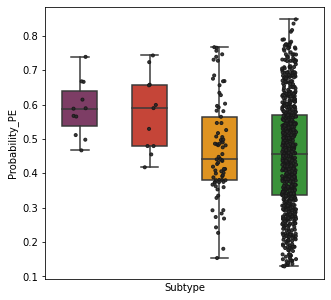

## Clinical_prob

specificity 0.7
AUC 0.76 CI95 (0.66, 0.96)
Specificity 0.7 Sensitivity 0.71 CI95 (0.57, 1.0)
AUC 0.77 CI95 (0.66, 0.92)
Specificity 0.7 Sensitivity 0.7 CI95 (0.5, 1.0)
AUC 0.68 CI95 (0.64, 0.72)
Specificity 0.7 Sensitivity 0.57 CI95 (0.51, 0.65)

specificity 0.8
AUC 0.76 CI95 (0.66, 0.96)
Specificity 0.8 Sensitivity 0.71 CI95 (0.57, 1.0)
AUC 0.77 CI95 (0.66, 0.92)
Specificity 0.8 Sensitivity 0.7 CI95 (0.5, 1.0)
AUC 0.68 CI95 (0.64, 0.72)
Specificity 0.8 Sensitivity 0.39 CI95 (0.29, 0.56)

specificity 0.9
AUC 0.76 CI95 (0.66, 0.96)
Specificity 0.9 Sensitivity 0.63 CI95 (0.5, 1.0)
AUC 0.77 CI95 (0.66, 0.92)
Specificity 0.9 Sensitivity 0.5 CI95 (0.25, 0.75)
AUC 0.68 CI95 (0.64, 0.72)
Specificity 0.9 Sensitivity 0.24 CI95 (0.16, 0.33)

EOPE Sensitivity at specificity 70 =  0.73
EOPE Sensitivity at specificity 80 =  0.73
EOPE Sensitivity at specificity 90 =  0.64
LOPE-PB Sensitivity at specificity 70 =  0.73
LOPE-PB Sensitivity at specificity 80 =  0.73
LOPE-PB Sensitivity

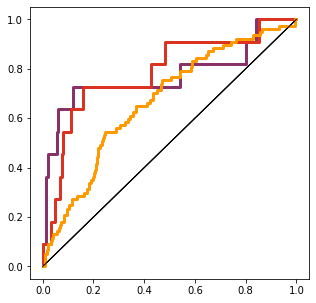

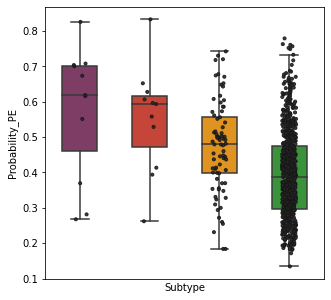

## Combined_prob

specificity 0.7
AUC 0.86 CI95 (0.79, 0.97)
Specificity 0.7 Sensitivity 0.8 CI95 (0.67, 1.0)
AUC 0.84 CI95 (0.78, 0.91)
Specificity 0.7 Sensitivity 0.84 CI95 (0.67, 1.0)
AUC 0.63 CI95 (0.6, 0.68)
Specificity 0.7 Sensitivity 0.45 CI95 (0.4, 0.53)

specificity 0.8
AUC 0.86 CI95 (0.79, 0.97)
Specificity 0.8 Sensitivity 0.8 CI95 (0.67, 1.0)
AUC 0.84 CI95 (0.78, 0.91)
Specificity 0.8 Sensitivity 0.76 CI95 (0.57, 1.0)
AUC 0.63 CI95 (0.6, 0.68)
Specificity 0.8 Sensitivity 0.37 CI95 (0.31, 0.43)

specificity 0.9
AUC 0.86 CI95 (0.79, 0.97)
Specificity 0.9 Sensitivity 0.63 CI95 (0.5, 1.0)
AUC 0.84 CI95 (0.78, 0.91)
Specificity 0.9 Sensitivity 0.47 CI95 (0.17, 0.75)
AUC 0.63 CI95 (0.6, 0.68)
Specificity 0.9 Sensitivity 0.17 CI95 (0.12, 0.27)

EOPE Sensitivity at specificity 70 =  0.82
EOPE Sensitivity at specificity 80 =  0.82
EOPE Sensitivity at specificity 90 =  0.64
LOPE-PB Sensitivity at specificity 70 =  0.82
LOPE-PB Sensitivity at specificity 80 =  0.73
LOPE-PB Sensitivity 

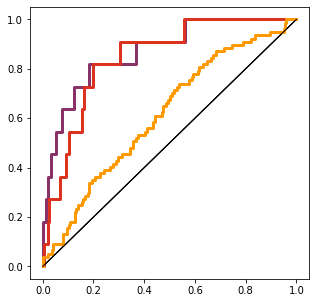

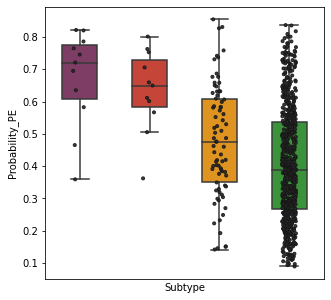

In [17]:
##Check performance on validation samples
data = Model_output.copy()
print("Total samples in PE Screening cohort =",len(data))

data["Actual"] = int(0)
data["Actual"][(data["Outcome"]=="PE")] = int(1)

print("Total",data["Actual"].value_counts())
for each_sub in data["Subtype"].unique():
    current = data[data["Subtype"]==each_sub]
    print(each_sub,"=",len(current))

#Plot ROC
print("#Performance metrics")
bootstrap_n = 1000
print("bootstrap_n",bootstrap_n)
subs = ['EOPE','LOPE-PB','LOPE-TB']
#subs = ['EOPEP','LOPEP_1']
color = ["#883268","#DC3220","#FF9900","#2ca02c"]
comb = ['Tissue_prob','Clinical_prob','Combined_prob']
set_n = -1
for each_comb in comb:
    set_n = set_n + 1
    print("##",each_comb)
    specificity_list = [0.70,0.80,0.90]
    for each_specificity in specificity_list:
        print("")
        print("specificity",each_specificity)
        AUC_range = []
        Sensitivity_range_DF = []
        for i in range(1,bootstrap_n+1):       
            NOP_samples = data[(data["Subtype"]=="NP")][["sample_ID"]]
            NOP_samples = NOP_samples.sample(len(NOP_samples), replace = True, random_state = i).drop_duplicates()
            PEP_samples = data[(data["Subtype"]!="NP")][["sample_ID"]]
            PEP_samples = PEP_samples.sample(len(PEP_samples), replace = True, random_state = i).drop_duplicates()
            Test_samples = pd.concat([NOP_samples,PEP_samples],axis =0)
            Test_samples = pd.merge(Test_samples,data,on = "sample_ID",how = "inner")
            Sensitivity_sub_DF = []
            AUC_sub = []
            n = -1
            for sub in subs:
                n +=1
                current_DF = Test_samples[(Test_samples["Subtype"] == "NP")|(Test_samples["Subtype"]==sub) ]
                AUC = roc_auc_score(current_DF["Actual"],current_DF[each_comb].values)
                AUC_sub.append(AUC)
                fpr, tpr, thresholds = roc_curve(current_DF["Actual"], current_DF[each_comb].values)        
                Sensitivity = round(tpr[sum(fpr <= 1 - each_specificity)],2)
                Sensitivity_sub_DF.append(Sensitivity)
            AUC_range.append(AUC_sub)
            Sensitivity_range_DF.append(Sensitivity_sub_DF)
        AUC_DF = pd.DataFrame(AUC_range,columns =subs)
        AUC_DF = AUC_DF.dropna()
        Sensitivity_DF = pd.DataFrame(Sensitivity_range_DF,columns =subs)
        Sensitivity_DF = Sensitivity_DF.dropna()

        for sub in subs:
            CI95 = round(list(AUC_DF[sub].sort_values())[int(bootstrap_n*0.05)],2),round(list(AUC_DF[sub].sort_values())[int(bootstrap_n*0.95)],2)
            print("AUC",round(AUC_DF[sub].mean(),2),"CI95",CI95)
            CI95 = round(list(Sensitivity_DF[sub].sort_values())[int(bootstrap_n*0.05)],2),round(list(Sensitivity_DF[sub].sort_values())[int(bootstrap_n*0.95)],2)
            print("Specificity",each_specificity,"Sensitivity",round(Sensitivity_DF[sub].mean(),2),"CI95",CI95)

    plt.figure(figsize=(5, 5))
    subs = ['EOPE','LOPE-PB','LOPE-TB']
    color = ["#883268","#DC3220","#FF9900","#2ca02c"]
    n = -1
    
    print("")
    for sub in subs:
        n+=1
        current_DF = data.copy()      
        current_DF = current_DF[(current_DF["Subtype"] == "NP")|(current_DF["Subtype"]==sub) ]
        AUC = roc_auc_score(current_DF["Actual"],current_DF[each_comb].values)
        fpr, tpr, thresholds = roc_curve(current_DF["Actual"], current_DF[each_comb].values)
        Sensitivity = round(tpr[sum(fpr <= 1 - 0.70)],2)
        print(sub, "Sensitivity at specificity 70 = ",Sensitivity)
        Sensitivity = round(tpr[sum(fpr <= 1 - 0.80)],2)
        print(sub, "Sensitivity at specificity 80 = ",Sensitivity)
        Sensitivity = round(tpr[sum(fpr <= 1 - 0.90)],2)
        print(sub, "Sensitivity at specificity 90 = ",Sensitivity)
        plt.plot(fpr,tpr, alpha = 1,lw =3,label = sub,color = color[n])
        plt.plot([0, 1], [0, 1], color='black',lw = 1);
    #plt.axvline(x=0.2, color='grey', linestyle='--')
    plt.savefig(path + '/Screening_Prob_ROC_set'+ str(set_n) +'.pdf', bbox_inches='tight');     
    plt.show()

    subs_with_NOP = subs + ["NP"]
    n = -1
    plt.figure(figsize=(5, 5))
    for sub in subs_with_NOP:
        n+=1
        current = data[data["Subtype"]==sub]
        current = current.sort_values(by = each_comb)
    ax = sns.boxplot(x="Subtype", y=each_comb, data=data,order =subs_with_NOP ,width = 0.5,fliersize=0,palette=color)
    ax = sns.stripplot(x="Subtype", y=each_comb, data=data,order =subs_with_NOP,color=".16",linewidth=1,alpha = 0.9,size=3)
    plt.xticks(rotation='vertical')
    plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off;
    plt.ylabel("Probability_PE");
    plt.show()